In [ ]:
#Import packages
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import fftpack
%matplotlib inline
font_size = 10
font_family = 'serif'
# Set Font Parameters
font = {'family': font_family, 'size': font_size}
plt.rc('font', **font)

In [ ]:
## Dimensional operators
cav_dim = 10 # types of photons there can exist (thermal or participaitn gin excitation)
atm_dim = 3 # energy levels in the atom, 2 for two-level system
I_cav = qeye(cav_dim) # identity matrix matching dimension of radiation field
I_atom = qeye(atm_dim) # identity matrix matching dimension of spin system

## Atomic basis states
one, two, three = basis(3,0), basis(3,1), basis(3,2) ## correponds to X, Y and Z levels

## Atomic raising and lowering operators
sigma13 = tensor((three * one.dag()), I_cav) # lowering from one to three
sigma31 = tensor((one * three.dag()), I_cav) # raising from three to one
sigma23 = tensor((three * two.dag()), I_cav) # lowering from two to three
sigma32 = tensor((two * three.dag()), I_cav) # raising from three to two
sigma12 = tensor((two * one.dag()), I_cav) # lowering from one to two
sigma21 = tensor((one * two.dag()), I_cav) # raising from two to one

## Atomic inversion operators
sigmaz31 = commutator(sigma31, sigma13)
sigmaz32 = commutator(sigma32, sigma23)
sigmaz21 = commutator(sigma21, sigma12)

## Photon operators
adag = tensor(I_atom, create(cav_dim)) # order of arguments is important and is consistant with the spin operators #add .unit()               
a = tensor(I_atom, destroy(cav_dim))

## Physical constants
N = 7e14
wc = 2 * np.pi * 1.45e3 # cavity frequency with vacuum field energy set to zero (zero-point energy) (MHz)
w13 = 2 * np.pi * 1.45e3 # atom transition frequency between levels 1 & 3 (MHz)
w23 = 2 * np.pi * 1.45e3 # atom transition frequency between levels 1 & 2 (MHz) under applied magnetic field
w12 = 2 * np.pi * 106.5 # atom transition frequency between levels 2 & 3 (MHz)
g13 = 2 * np.pi * 0.042e-6 # collective spin-photon couling strength ~ np.sqrt(tls_num)*g, experimetnally it's 1.1 though.
g23 = 2 * np.pi * 0.042e-6
#assume the coupling strength is equal, because the cavity mode should be equally detuned from both transitions. 
#gs = 2 * np.pi * 0.042e-6 # single spin–photon coupling strength (MHz)

Kc = 2 * np.pi * 0.18 # cavity mode decay rate (MHz)
Ks = 2 * np.pi * 0.11 # spin dephasing rate (MHz)
gamma = 2 * np.pi * 0.011 # spin-lattice relaxation rate (MHz)

## Initial quantum states
psi_atm = np.sqrt(0.76)*one + np.sqrt(0.16)*two + np.sqrt(0.08)*three
psi_phot = coherent(cav_dim, np.sqrt(1))
psi0 = tensor(psi_atm, psi_phot)
rho0 = ket2dm(psi0)


## Assembling the Hamiltonian
HA1 = 0.5 * (w13*sigmaz31) #+ 0.5 * (w23*sigmaz32) #+(w23*sigmaz23) atomic part
HF1 = w13 * (adag*a) #+ w23 * (adag*a) # field part
HI1 = np.sqrt(N)*g13*(sigma31*a + sigma13*adag) #+ g23*(sigma32*a + sigma23*adag)  # interaction part in the RWA
H1 = HA1 + HF1 + HI1

HA2 = + 0.5 * (w23*sigmaz32) #+(w23*sigmaz23) atomic part
HF2 = w23 * (adag*a) # field part
HI2 = np.sqrt(N)*g13*(sigma32*a + sigma23*adag)  # interaction part in the RWA
H2 = HA2 + HF2 + HI2

H = H1 + H2


## simulation duration and master equation solver
time = 40
steps = 500
tlist = np.linspace(0.0, time, steps)
result = mesolve(H, rho0, tlist, [np.sqrt(0.1)*a], [adag*a, sigmaz31, sigmaz32, sigma31*sigma13, sigma32*sigma23, adag*sigma13, adag*sigma23], options=Options(nsteps=15000))

## Visualization 
plt.figure(1)
plt.plot(tlist, result.expect[0], 'r')
plt.title('Cavity photon number')
plt.ylabel('⟨ ${a^\dag}a$ ⟩')
plt.xlabel('Time (μs)')
plt.savefig('adag a.png', format = 'png', dpi = 900) 

plt.figure(2)
plt.plot(tlist, result.expect[1], 'k')
plt.plot(tlist, result.expect[2], 'm')
plt.legend(("X to Z transition", "Y to Z transition"))
plt.title('Population Inversion')
plt.ylabel('⟨ ${σ_z}$ ⟩')
plt.xlabel('Time (μs)')
plt.savefig('sigmaz.png', format = 'png', dpi = 900) 

plt.figure(3)
plt.plot(tlist, result.expect[3], 'b')
plt.plot(tlist, result.expect[4], 'c')
plt.legend(("Left leg", "Right leg"))
plt.title('Spin-spin correlation')
plt.ylabel('⟨ ${σ_+ σ_-}$ ⟩')
plt.xlabel('Time (μs)')
plt.savefig('sigmap sigmam.png', format = 'png', dpi = 900) 

plt.figure(4)
plt.plot(tlist, result.expect[5])
plt.plot(tlist, result.expect[6])
plt.legend(("X to Z transition", "Y to Z transition"))
plt.title('Spin-photon correlation')
plt.ylabel('⟨ ${a^\dag σ_-}$ ⟩')
plt.xlabel('Time (μs)')
plt.savefig('adag sigmam.png', format = 'png', dpi = 900)


y1 = fft(result.expect[5])
y2 = fft(result.expect[6])
amp = np.abs(y1)
xf = fftfreq(result.expect[5].size, d=time/steps) # takes window length and inverse of sampling rate as input
plt.figure(5)
plt.plot(xf, y1)
plt.plot(xf, y2)
plt.legend(("X to Z transition", "Y to Z transition"))
plt.title('FFT spin-photon correlation')
plt.ylabel('⟨ ${a^\dag σ_-}$ ⟩')
plt.xlabel('Frequency (MHz)')
plt.savefig('fft adag sigmam.png', format = 'png', dpi = 900)

amp_freq = np.array([amp, xf])
amp_pos = amp_freq[0,:].argmax()
peak_freq = amp_freq[1, amp_pos]
print(amp_pos)
print(peak_freq)

plt.show()

In [ ]:
corr1 = correlation_2op_1t(H1, None, tlist, [np.sqrt(0.1) * a], sigma13, adag, options=Options(nsteps=5000))
corr2 = correlation_2op_1t(H1, None, tlist, [np.sqrt(1.0) * a], adag, adag, options=Options(nsteps=5000))
corr3 = correlation_2op_1t(H1, None, tlist, [np.sqrt(5.0) * a], adag, adag, options=Options(nsteps=5000))

figure()
plot(tlist, np.real(corr1), tlist, np.real(corr2), tlist, np.real(corr3))


legend(['0.1','1.0','5.0'])
xlabel(r'Time $t$')
ylabel(r'Correlation $\left<x(t)x(0)\right>$')
show()

cy_ode_psi_func_td


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


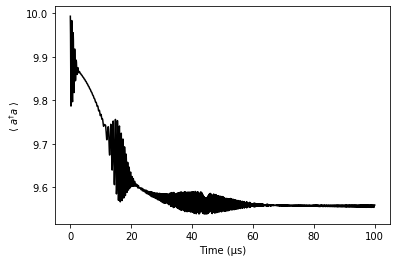

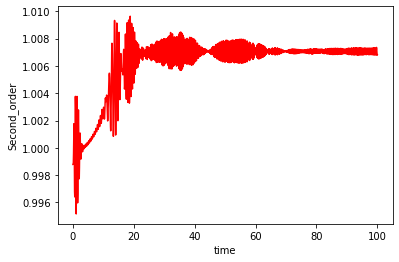

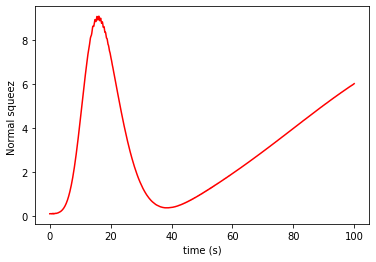

In [5]:
from qutip import *
import matplotlib.pyplot as plt
import numpy as np
from pylab import *  

cav_dim = 20
atm_dim = 3

#reminder: basis(3,0) is the higehst state of 3, basis(3,2) is the lowest state of 3. 

# atomic operators
sm = tensor(qeye(cav_dim), destroy(atm_dim)) # lowering operator for atom
s11= tensor(qeye(cav_dim), basis(3,0)*basis(3,0).dag()) # deletes state, unless acting on 3
s22= tensor(qeye(cav_dim), basis(3,1)*basis(3,1).dag()) # deletes state, unless acting on 2
s33= tensor(qeye(cav_dim), basis(3,2)*basis(3,2).dag()) # deletes state, unless acting on 1

s12= tensor(qeye(cav_dim), basis(3,0)*basis(3,1).dag()) # raising from 2 to 3
s13= tensor(qeye(cav_dim), basis(3,0)*basis(3,2).dag()) # raising from 1 to 3
s23= tensor(qeye(cav_dim), basis(3,1)*basis(3,2).dag()) # raising from 1 to 2

nq = sm.dag() * sm
xq = sm + sm.dag()
sz=s11-s22
I = tensor(qeye(cav_dim), qeye(atm_dim))

delta1 = 10.0     # first detuning
delta2 = 10.0     # second detuning 
kg = 0.9         # gravity operator 

#field operators
a = tensor(destroy(N), qeye(3))
nc = a.dag() * a
xc = a + a.dag()

# dispersive hamiltonian
H1 = a * s12 
H2 = a.dag()* s12.dag()
H3 = a * s13
H4 = a.dag()* s13.dag()
args = (H1, H2, H3, H4)

# The Hamiltonian of the atom-field system 
# in the presence of classical homogenous gravitational field
def hamiltonian_t(t, args):
    H1 = args[0]
    H2 = args[1]
    H3 = args[2]
    H4 = args[3]
    return (exp(1j*(delta1*t-(kg*t**2)/2))*H1+exp(-1j*(delta1*t-(kg*t**2)/2))*H2)+\
           (exp(1j*(delta2*t-(kg*t**2)/2))*H3+exp(-1j*(delta2*t-(kg*t**2)/2))*H4) 

#time 
tlist = linspace(0, 100, 1500)

# collapse operators, only active if gamma1 > 0
c_ops = []

# atom and the field are initially prepared in the excited and coherent state 
psi0 = tensor(coherent(N, sqrt(10)), (basis(3,2)).unit())
res = mesolve(hamiltonian_t, psi0, tlist, c_ops, [], args)


# The expectation values of the photon number
def Mean_photon(level_n, states):
    a = tensor(destroy(N), qeye(level_n))
    nc = a.dag() * a
    NC1 = expect(nc, states)
    return NC1

def Second_order(level_n, states):
    a= tensor(destroy(N), qeye(level_n))
    ncc= (a.dag()*a)**2
    nc = a.dag() * a
    NC1 = expect(nc, states)
    NCC1 = expect(ncc, states)
    Q=(NCC1-NC1)/NC1**2
    return Q    

def Normal_Sqx(level_n, states):
    a= tensor(destroy(N), qeye(level_n))
    nc = a.dag() * a
    nf = a + a.dag()
    aa = a**2
    ad = a.dag()**2
    aae= expect(aa, states)
    ade= expect(ad, states)
    nfe= expect(nf, states)
    NC1 = expect(nc, states)
    Sx = 0.25*(2* NC1+ aae+ 1+ ade- (nfe)**2)-0.25  
    return Sx

mean=Mean_photon(3, res.states)
sec= Second_order(3, res.states)
Norm=Normal_Sqx(3, res.states)

plt.figure(1)
plt.plot(tlist, mean ,"k-")
plt.title('Cavity photon number')
plt.ylabel('⟨ ${a^\dag}a$ ⟩')
plt.xlabel('Time (μs)')
plt.savefig('adag a 3lvl.png', format = 'png', dpi = 900)

plt.figure(2)
plt.plot(tlist, sec ,"r-")
plt.xlabel('time')
plt.ylabel('Second_order')

plt.figure(3)
plt.plot(tlist, Norm ,"r-")
plt.xlabel('time (s)')
plt.ylabel('Normal squeeze')

plt.show()

In [ ]:
# QuTiP function explicity

#coherent state 
def CS(N, alpha, offset=0, method='operator'):
    x = basis(N, 0)
    a = destroy(N)
    D = (alpha * a.dag() - conj(alpha) * a).expm()
    return D * x


def Normal_Sqy(level_n, states):
    a= tensor(destroy(N), qeye(level_n))
    nc = a.dag() * a
    nf = a - a.dag()
    aa = a**2
    ad = a.dag()**2
    aae= expect(aa, states)
    ade= expect(ad, states)
    nfe= expect(nf, states)
    NC1 = expect(nc, states)
    Sy = (2*NC1- aae- ade +1+ (nfe)**2)*(1/4)-(1/4)    
    return Sy  

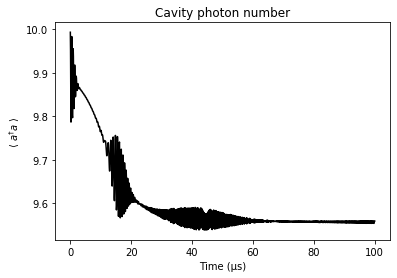

In [6]:
plt.figure(1)
plt.plot(tlist, mean ,"k-")
plt.title('Cavity photon number')
plt.ylabel('⟨ ${a^\dag}a$ ⟩')
plt.xlabel('Time (μs)')
plt.savefig('adag a 3lvl.png', format = 'png', dpi = 900)

To check the validity of my model I should do the Fourier transform to determine the Rabi frequency. I should compare this to the theoretically calculated Rabi frequency from Jerry & Night. 